<a href="https://colab.research.google.com/github/bacnc1/Medical-Image-Analysis/blob/main/Cardiac_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install pydicom
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 75.5 MB/s eta 0:00:00


In [7]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

In [8]:
labels = pd.read_csv("/content/rsna_heart_detection.csv")

In [9]:
labels.head()

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


In [1]:
!pip install -q kaggle


In [2]:
from google.colab import files
files.upload()  # Use this to upload your kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bacnc1","key":"2c415532a6ee0a7b5b1cbf7b85080693"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json




In [4]:
!kaggle datasets list


ref                                                          title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
valakhorasani/mobile-device-usage-and-user-behavior-dataset  Mobile Device Usage and User Behavior Dataset   11KB  2024-09-28 20:21:12          11206        211  1.0              
satvshr/top-4-used-car-sales-datasets-combined               Top 4 Used Car Sales Datasets Combined         446KB  2024-10-21 13:20:56           1374         28  0.9411765        
bhadramohit/credit-card-fraud-detection                      Credit Card Fraud Detection                      2MB  2024-10-21 09:26:17            744         21  1.0              
valakhorasani/gym-members-exercise-dataset                   Gym Members Exercise Dataset           

In [5]:
!kaggle competitions download -c rsna-pneumonia-detection-challenge

100% 3.66G/3.66G [03:00<00:00, 19.6MB/s]
100% 3.66G/3.66G [03:00<00:00, 21.7MB/s]


In [ ]:
!unzip /content/rsna-pneumonia-detection-challenge.zip

In [11]:
ROOT_PATH = Path("/content/stage_2_train_images")
SAVE_PATH = Path("Processed-Heart-Detection")

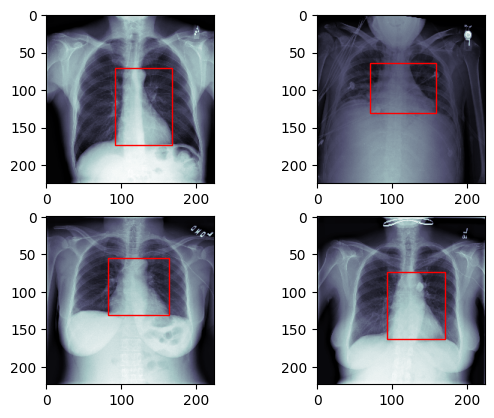

In [12]:
fig, axis = plt.subplots(2, 2)
c=0
for i in range(2):
  for j in range(2):
    data=labels.iloc[c]
    patient_id=data["name"]
    dcm_path = ROOT_PATH / str(patient_id)
    dcm_path = dcm_path.with_suffix(".dcm")
    dcm = pydicom.dcmread(dcm_path)
    dcm_arr = dcm.pixel_array
    dcm_arr = cv2.resize(dcm_arr, (224, 224))

    x = data["x0"]
    y = data["y0"]
    width = data["w"]
    height = data["h"]
    axis[i][j].imshow(dcm_arr, cmap="bone")
    rect = patches.Rectangle((x, y), width, height, edgecolor="r", fill=False)
    axis[i][j].add_patch(rect)
    c+=1
plt.show()




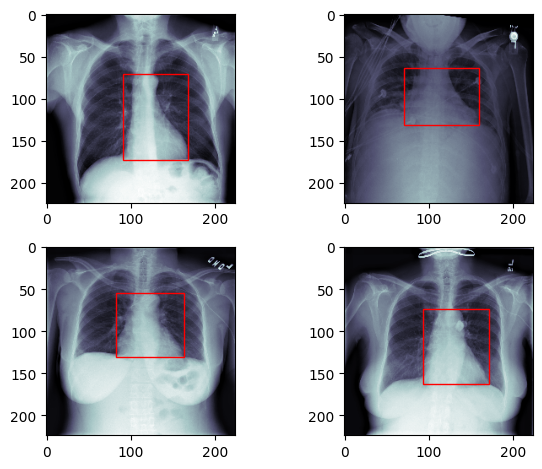

In [13]:
fig, axis = plt.subplots(2, 2)
c = 0
for i in range(2):
    for j in range(2):
        data = labels.iloc[c]  # Get the c-th row of the labels

        patient_id = data["name"]
        dcm_path = ROOT_PATH/str(patient_id)  # Create the path to the dcm file
        dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix
        dcm = pydicom.dcmread(dcm_path)  # Read the dicom file with pydicom

        # Retrieve the actual image and resize it to match the labels
        dcm_array = dcm.pixel_array
        dcm_array = cv2.resize(dcm_array, (224, 224))

        x = data["x0"]
        y = data["y0"]
        width = data["w"]
        height = data["h"]

        axis[i][j].imshow(dcm_array, cmap="bone")
        rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        axis[i][j].add_patch(rect)

        c+=1
plt.tight_layout()

In [14]:
sums = 0
sums_squared = 0
train_ids = []
val_ids = []

for counter, patient_id in enumerate(list(labels.name)):
    dcm_path = ROOT_PATH/patient_id  # Create the path to the dcm file
    dcm_path = dcm_path.with_suffix(".dcm")  # And add the .dcm suffix

    dcm = pydicom.dcmread(dcm_path)  # Read the dicom file with pydicom

     # Retrieve the actual image
    dcm_array = dcm.pixel_array
    assert dcm_array.shape == (1024, 1024)

    # Resize the image to drastically improve training speed
    # In order to reduce the space when storing the image we convert it to float16
    # Standardize to 0-1 range
    dcm_array = (cv2.resize(dcm_array, (224, 224)) / 255).astype(np.float16)

    # 4/5 train split, 1/5 val split
    train_or_val = "train" if counter < 400 else "val"

    # Add to corresponding train or validation patient index list
    if train_or_val == "train":
        train_ids.append(patient_id)
    else:
        val_ids.append(patient_id)

    current_save_path = SAVE_PATH/train_or_val # Define save path and create if necessary
    current_save_path.mkdir(parents=True, exist_ok=True)

    np.save(current_save_path/patient_id, dcm_array)  # Save the array in the corresponding directory

    normalizer = dcm_array.shape[0] * dcm_array.shape[1]  # Normalize sum of image
    if train_or_val == "train":  # Only use train data to compute dataset statistics
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer


In [15]:
sums

197.72066326530597

In [16]:
np.save("Processed-Heart-Detection/train_subjects_det", train_ids)
np.save("Processed-Heart-Detection/val_subjects_det", val_ids)

In [17]:
mean = sums / len(train_ids)
std = np.sqrt(sums_squared / len(train_ids) - (mean**2), dtype=np.float64)

In [18]:
print(f"Mean of Dataset: {mean}, STD: {std}")

Mean of Dataset: 0.49430165816326493, STD: 0.2527964897943661


In [19]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import imgaug
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage



In [25]:
class CardiacDataset(torch.utils.data.Dataset):

    def __init__(self, path_to_labels_csv, patients, root_path, augs):

        self.labels = pd.read_csv(path_to_labels_csv)

        self.patients = np.load(patients)
        self.root_path = Path(root_path)
        self.augment = augs

    def  __len__(self):
        """
        Returns the length of the dataset
        """
        return len(self.patients)

    def __getitem__(self, idx):
        """
        Returns an image paired with bbox around the heart
        """
        patient = self.patients[idx]
        # Get data according to index
        data = self.labels[self.labels["name"]==patient]

        # Get entries of given patient
        # Extract coordinates

        x_min = data["x0"].item()
        y_min = data["y0"].item()
        x_max = x_min + data["w"].item()  # get xmax from width
        y_max = y_min + data["h"].item()  # get ymax from height
        bbox = [x_min, y_min, x_max, y_max]


        # Load file and convert to float32
        file_path = self.root_path/patient  # Create the path to the file
        img = np.load(f"{file_path}.npy").astype(np.float32)


        # Apply imgaug augmentations to image and bounding box
        if self.augment:

            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])

            ###################IMPORTANT###################
            # Fix for https://discuss.pytorch.org/t/dataloader-workers-generate-the-same-random-augmentations/28830/2
            # https://github.com/pytorch/pytorch/issues/5059
            random_seed = torch.randint(0, 1000000, (1,)).item()
            imgaug.seed(random_seed)
            #####################################################

            img, aug_bbox  = self.augment(image=img, bounding_boxes=bb)
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]


        # Normalize the image according to the values computed in Preprocessing
        img = (img - 0.494) / 0.252

        img = torch.tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)

        return img, bbox


In [26]:
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [27]:
# First create the augmentation object

seq = iaa.Sequential([
            iaa.GammaContrast(),
            iaa.Affine(
                scale=(0.8, 1.2),
                rotate=(-10, 10),
                translate_px=(-10, 10)
            )
        ])


In [28]:
labels_path = "/content/rsna_heart_detection.csv"
patients_path = "/content/Processed-Heart-Detection/train_subjects_det.npy"
train_root = "/content/Processed-Heart-Detection/train"
dataset = CardiacDataset(labels_path, patients_path, train_root, seq)

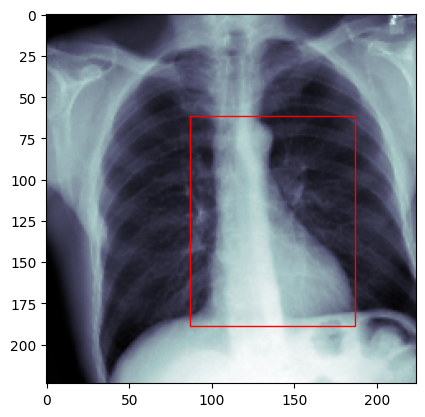

In [29]:
img, bbox = dataset[0]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor="r", facecolor="none")
axis.add_patch(rect)

tensor([ 52.1952,  37.2519, 185.0402, 187.5675])


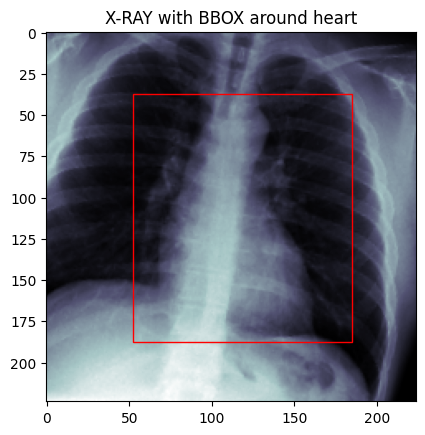

In [30]:
img, label = dataset[17]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
spot1 = patches.Rectangle((label[0], label[1]), label[2]-label[0], label[3]-label[1], edgecolor='r', facecolor='none')
axis.add_patch(spot1)

axis.set_title("X-RAY with BBOX around heart")
print(label)